In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import utils
slim = tf.contrib.slim

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)



## Hyperparameters

In [2]:
params = dict(
    batch_size=256,
    unl_batch_size = 256,
    learning_rate=3e-4,
    beta1=0.5,
    epoch=2000,
    epsilon=1e-8,
    max_iter=16000,
    viz_every=500,
    z_dim=2,
    x_dim=2,
    optimizer='rmsprop', # rmsprop sgd sga
    seed = 122524,
    nabla = 0,
    reg_w = 10. 
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data Creation

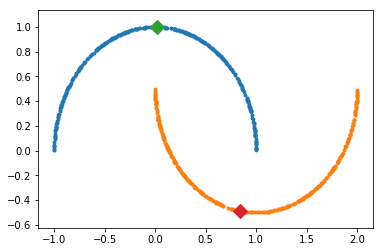

In [3]:
labeled =1
x,y=make_moons(n_samples=2000, shuffle=True, noise=0., random_state=rng.randint(2**10))
trainx, testx, trainy, testy = train_test_split(x, y, test_size=0.33, random_state=rng.randint(2**10))
trainx_unl = trainx.copy()

inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']

utils.scatter_2_class(testx,testy,s=8)
# utils.scatter_2_class(trainx_unl,np.ones(trainx_unl.shape[0]),s=1,c='k')
utils.scatter_2_class(trainx,trainy,marker = 'D',s=100)
plt.show()


In [4]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

## Build model

In [5]:
tf.reset_default_graph()

In [6]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['unl_batch_size'])

train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params['batch_size'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params['batch_size'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
training_init_op = iterator.make_initializer(train_dataset)
validation_init_op = iterator.make_initializer(test_dataset)

iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

In [7]:
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

optimizer = tf.train.RMSPropOptimizer(params['learning_rate'])

d_grads = tf.gradients(loss, disc_vars)
g_grads = tf.gradients(-loss, gen_vars)

variables = disc_vars + gen_vars
grads = d_grads + g_grads
    
reg = 0.5 * sum(tf.reduce_sum(tf.square(g)) for g in grads)
Jgrads = tf.gradients(reg, variables)

apply_vec = [(g + params['reg_w'] * Jg, v)for (g, Jg, v) in zip(grads, Jgrads, variables) if Jg is not None]

global_step = tf.Variable(0, name='global_step',trainable=False)
with tf.control_dependencies([g for (g, v) in apply_vec]):
    train_op = optimizer.apply_gradients(apply_vec, global_step=global_step)    
        

## Vector Field

In [8]:
perturb = tf.random_normal([params['batch_size'],params['z_dim']], mean=0, stddev=1)
perturb = tf.nn.l2_normalize(perturb, dim=[1])
z_pert = noise + 1e-4* perturb
samples_perturb = generator(z_pert, output_dim=params['x_dim'], reuse=True)

#to get ops on a loaded meta graph
samples_perturb = tf.identity(samples_perturb,name='sample_perturb')
samples = tf.identity(samples,name='samples')

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [10]:
saver = tf.train.Saver()

In [12]:
if tf.train.latest_checkpoint('./saved_models/') is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint('./saved_models/'))
else:
    print('no model found')

INFO:tensorflow:Restoring parameters from ./saved_models/gan_latent_2dim


global step: 1


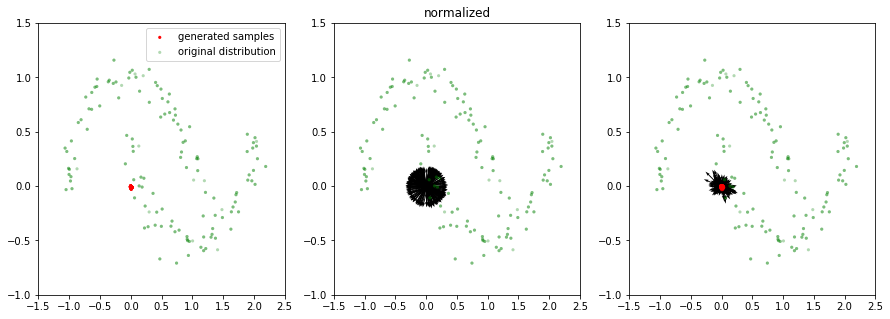

global step: 501


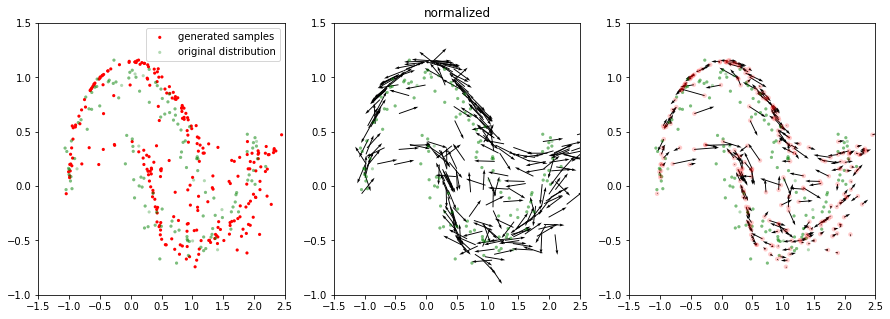

global step: 1001


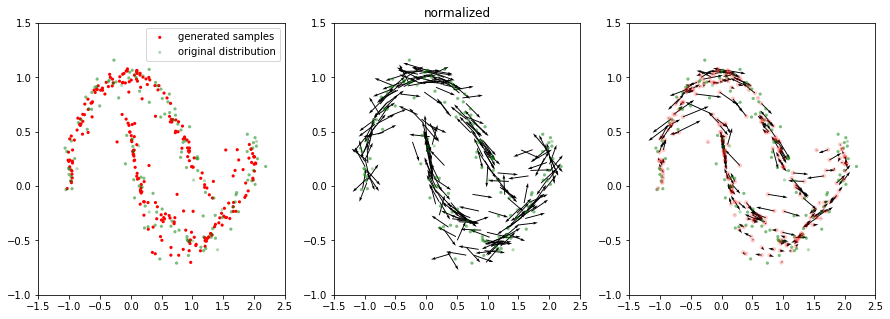

global step: 1501


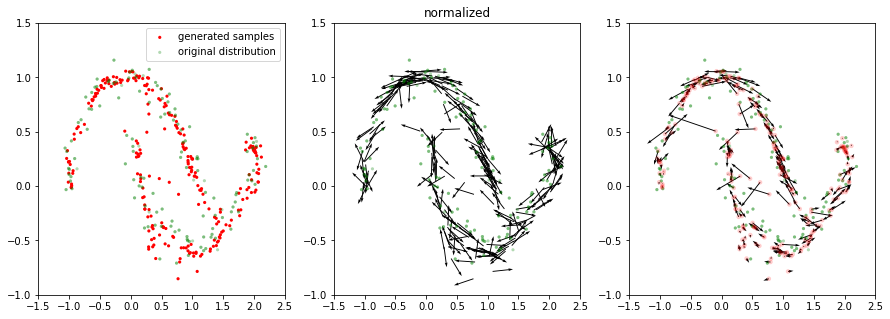

global step: 2001


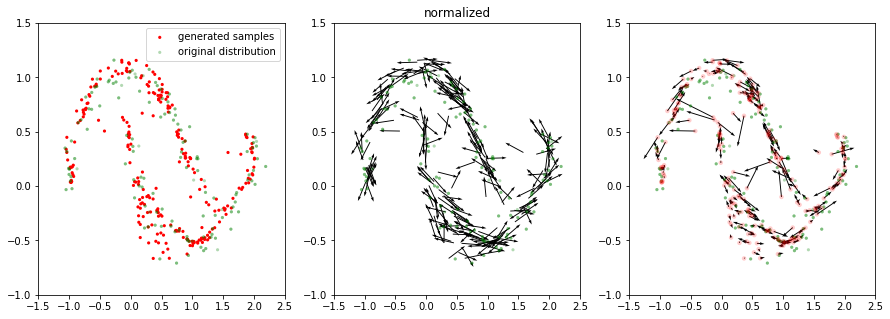

global step: 2501


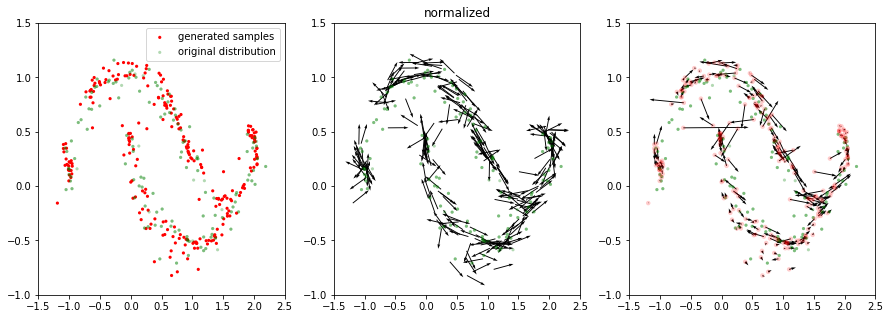

global step: 3001


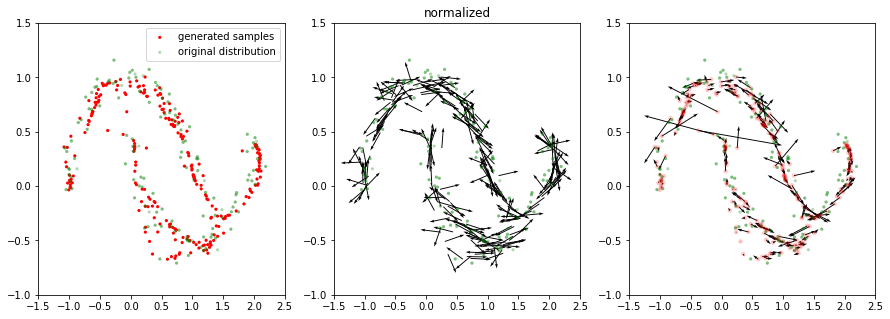

global step: 3501


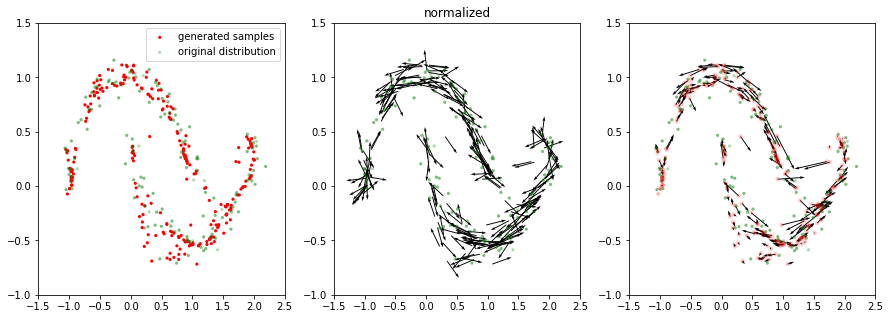

global step: 4001


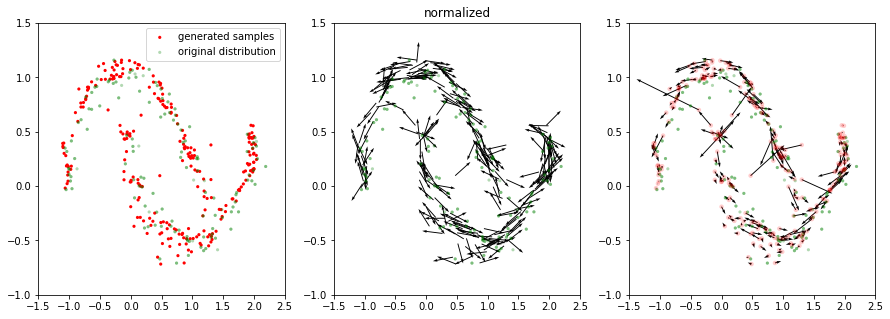

global step: 4501


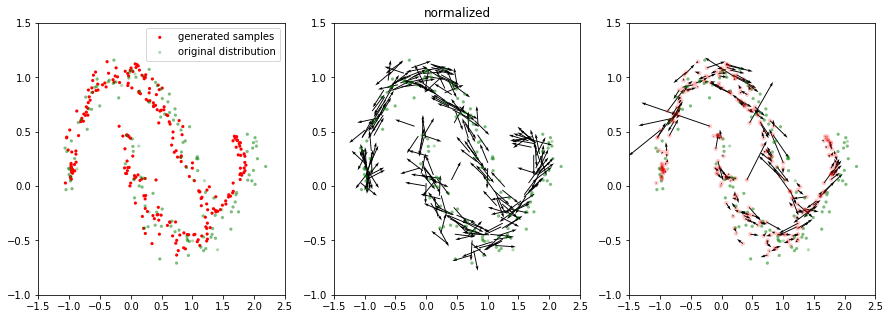

global step: 5001


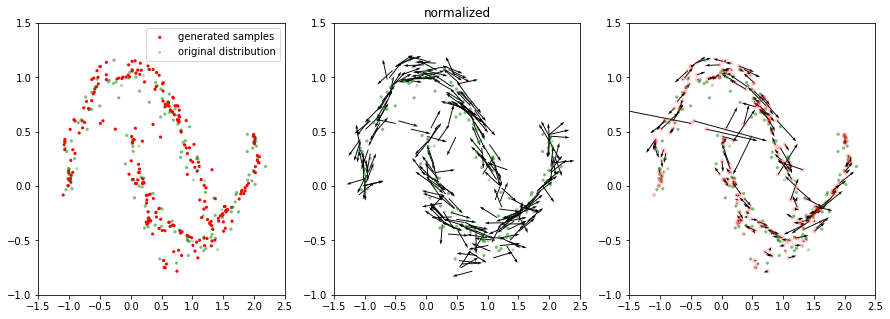

global step: 5501


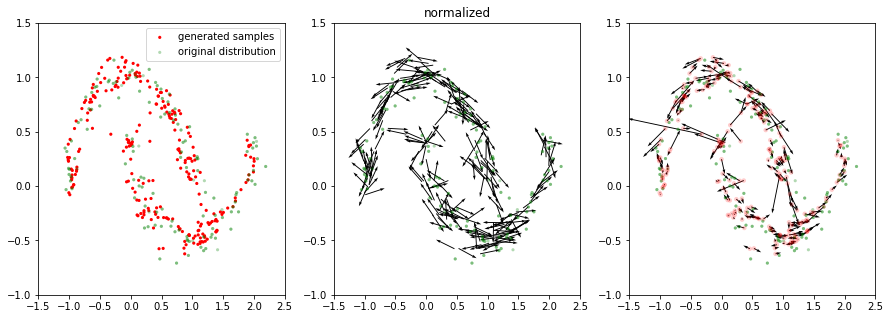

global step: 6001


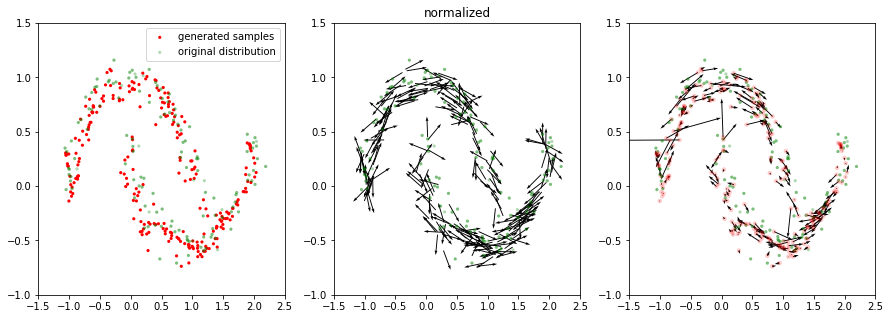

global step: 6501


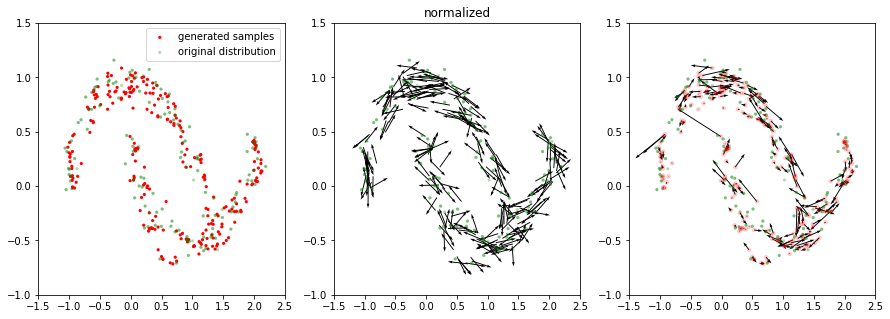

global step: 7001


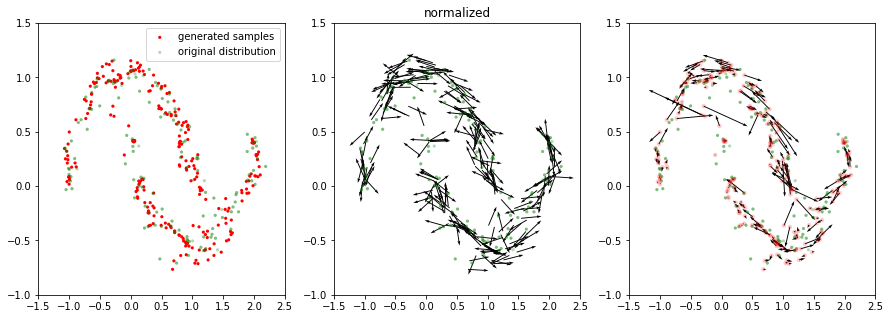

global step: 7501


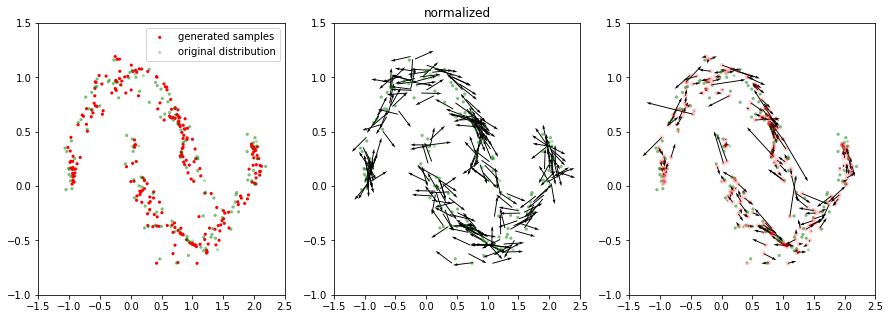

global step: 8001


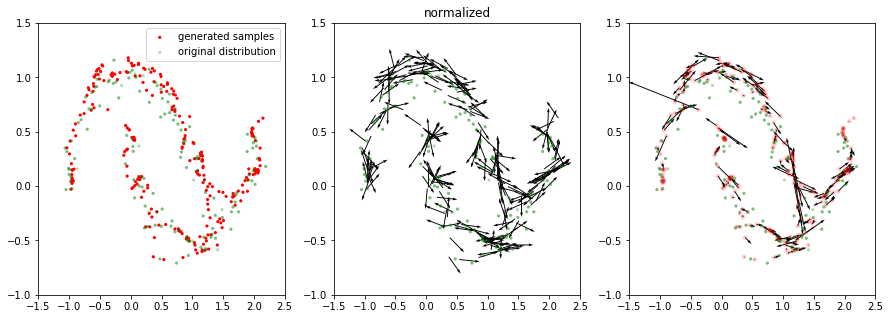

global step: 8501


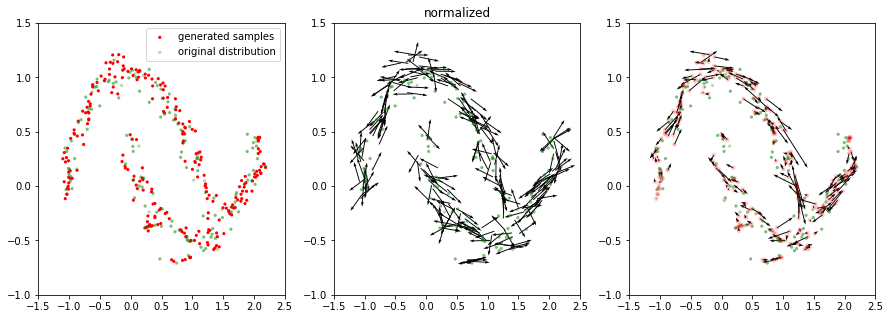

global step: 9001


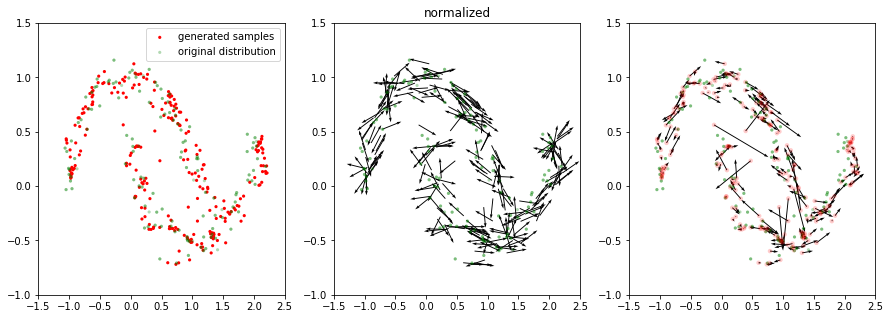

global step: 9501


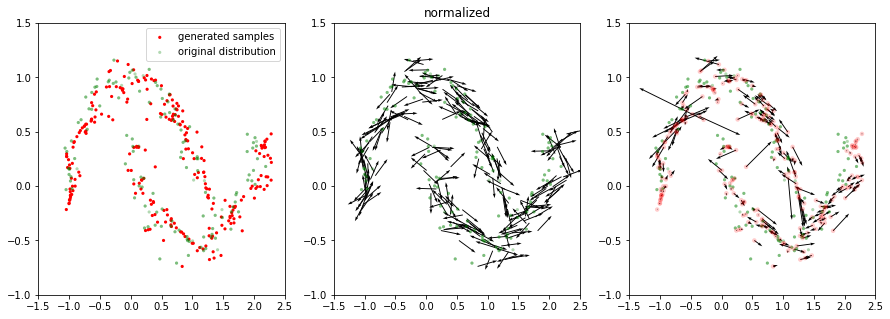

global step: 10001


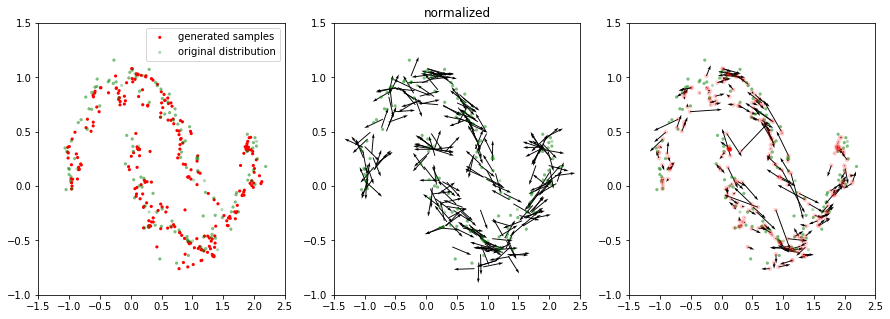

global step: 10501


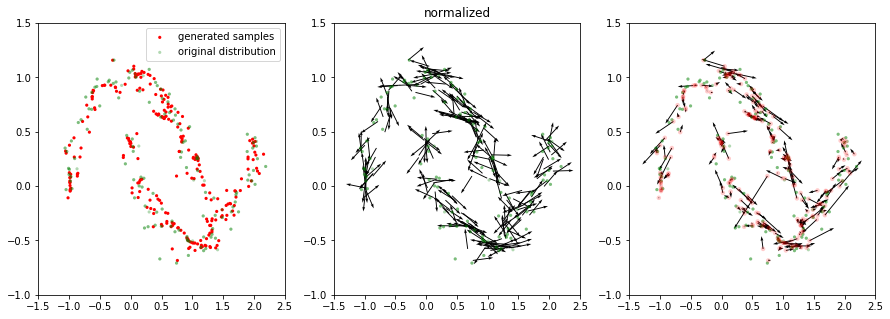

KeyboardInterrupt: 

In [11]:
fs = []
frames = []
np_samples = []
n_batches_viz = 1
viz_every = params['viz_every']
n_quiver = 8000

yy = np.vstack([sess.run(data) for _ in range(n_batches_viz)])

for i in tqdm(range(params['max_iter']+1)):
    f, _= sess.run([[loss], train_op])
    
    fs.append(f)
    if (i) % viz_every == 0:
        xx, zz = sess.run([samples,samples_perturb])      
        uu = zz - xx 
        norm = np.linalg.norm(uu,axis=1,keepdims=1)
        uu_n = uu / (norm * np.ones([1,2]))
        
        print("global step:", sess.run(global_step))
        fig = plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10,c='r')
        plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
#         plt.scatter(zz[:, 0], zz[:, 1], edgecolor='none',s=10,alpha = 0.3)
        plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
        plt.legend(['generated samples','original distribution'])

        plt.subplot(132)
        plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu_n[:n_quiver,0], uu_n[:n_quiver,1],scale = 12)
        plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
        plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
#         plt.legend(['normalized local perturabtion','samples original distrinbution'])
        plt.title('normalized')
        
        plt.subplot(133)
        plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
        plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu[:n_quiver,0], uu[:n_quiver,1])
        plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
        plt.scatter(xx[:n_quiver, 0], xx[:n_quiver, 1], edgecolor='none',s=20,c='r',alpha = 0.2)
#         plt.scatter(zz[:n_quiver, 0], zz[:n_quiver, 1], edgecolor='none',s=20)
#         for i in range(n_quiver):
#             plt.arrow(xx[i,0], xx[i,1], uu[i,0], uu[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k',alpha=0.4,color='r')
        
        plt.show()

In [14]:
# name = 'con_gan_000'
# save_path = os.path.join('./saved_models/',name)
saver.save(sess, './saved_models/gan_latent_2dim')

'./saved_models/gan_latent_2dim'

## Classifier

In [13]:
def classifier(x, n_hidden=40, n_layer=2, reuse=False):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None,weights_regularizer=slim.l2_regularizer(0.1))
    return log_d

In [80]:
labeled_data = tf.cast(next_element,tf.float32)
lbl = tf.cast(next_label,tf.float32)

with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.2)):
        logits = tf.squeeze(classifier(labeled_data))
        logits_gen = tf.squeeze(classifier(samples,reuse = True))
        logits_gen_perturb = tf.squeeze(classifier(samples_perturb,reuse = True))

_nabla = tf.gradients(logits_gen, noise)[0]
print(_nabla)
# nabla_loss = tf.reduce_mean(_nabla)
_l2 = tf.losses.get_regularization_losses()

soft_pred = tf.nn.softmax(logits)

xloss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=lbl)) 

loss = xloss
with tf.variable_scope('classifier_optimizer', reuse = tf.AUTO_REUSE):
    optimizer = tf.train.RMSPropOptimizer(params['learning_rate'])
    train_op = optimizer.minimize(loss)
    accuracy = utils.accuracy(logits,next_label)
    prediction = utils.prediction(logits)

Tensor("gradients_4/generator/Stack/fully_connected_1/MatMul_grad/MatMul:0", shape=(256, 2), dtype=float32)


In [81]:
# tf.variables_initializer(tf.get)
var = tf.global_variables(scope='classifier')
init_op = tf.variables_initializer(var_list=var)

In [82]:
xls=[]; jls =[]; 
reg = []
sess.run(init_op)
sess.run(training_init_op)
for i in tqdm(range(params['epoch']+1)):
    xl, _, acc = sess.run([xloss, train_op, accuracy])
    xls.append(xl); 
    if i % 100 == 0:
        print("Epoch: {}, loss: {:.5f}, training accuracy: {:.2f}%".format(i, xl, acc * 100))

    if i % 500 == 0:
        sess.run(validation_init_op)
        avg_acc = 0; pred = []; valid_iters = nr_batch_test;
        for i in range(valid_iters):
            acc,p = sess.run([accuracy,prediction])
            avg_acc += acc
            pred.append(p);
        print("Average validation set accuracy over {} iterations is {:.2f}%".format(valid_iters,(avg_acc / valid_iters) * 100))
        pred = np.concatenate(pred);
        sess.run(training_init_op)


Epoch: 0, loss: 0.71730, training accuracy: 31.64%
Average validation set accuracy over 1 iterations is 31.25%
Epoch: 100, loss: 0.64816, training accuracy: 87.11%
Epoch: 200, loss: 0.48568, training accuracy: 83.59%
Epoch: 300, loss: 0.33850, training accuracy: 87.50%
Epoch: 400, loss: 0.28557, training accuracy: 87.11%
Epoch: 500, loss: 0.21909, training accuracy: 90.62%
Average validation set accuracy over 1 iterations is 86.33%
Epoch: 600, loss: 0.18438, training accuracy: 89.84%
Epoch: 700, loss: 0.15939, training accuracy: 91.80%
Epoch: 800, loss: 0.14377, training accuracy: 91.80%
Epoch: 900, loss: 0.12302, training accuracy: 95.31%
Epoch: 1000, loss: 0.10728, training accuracy: 95.31%
Average validation set accuracy over 1 iterations is 89.45%
Epoch: 1100, loss: 0.10340, training accuracy: 95.70%
Epoch: 1200, loss: 0.09750, training accuracy: 96.48%
Epoch: 1300, loss: 0.07081, training accuracy: 98.44%
Epoch: 1400, loss: 0.06159, training accuracy: 98.83%
Epoch: 1500, loss: 0.0

In [83]:
x_pl = tf.placeholder(tf.float32,[None,2])
logits_pl = tf.squeeze(classifier(x_pl))
soft_pl = logits_pl
x_min =-1.5; x_max = 2.5; y_min = -1; y_max = 1.5; h = 0.01;
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.vstack([xx.ravel(),yy.ravel()]).T
zz = sess.run(soft_pl,{x_pl:grid})

softmax = lambda x: 1/(1+np.exp(-x))
zz=softmax(zz)

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  s)


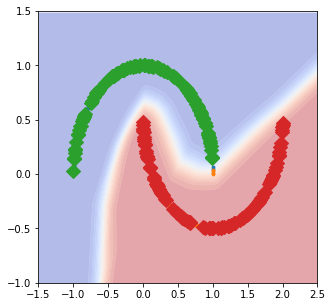

In [84]:
n_test = len(pred)
fig = plt.figure(figsize=(5,5))
# plt.subplot(121)
cnt = plt.contourf(xx, yy, zz.reshape(xx.shape),20,cmap=plt.cm.coolwarm, alpha=0.4,edgecolor=None)
# plt.contour(xx, yy, zz.reshape(xx.shape),1,map=plt.cm.binary, alpha=0.5,linewidths=2,linestyles='solid')
utils.scatter_2_class(testx[:n_test],pred,s=8)
utils.scatter_2_class(trainx,trainy, marker='D',s=100)
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])


# This is the fix for the white lines between contour levels
for c in cnt.collections:
    c.set_edgecolor("face")
    c.set_linewidth(1e-9)
# plt.subplot(122)
# utils.scatter_2_class(testx[:n_test],pred,s=8)
# utils.scatter_2_class(trainx,trainy, marker='D',s=100)
# plt.legend(['_','_','labeled datapoint'])
# plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])


plt.show()    

global step: 4122


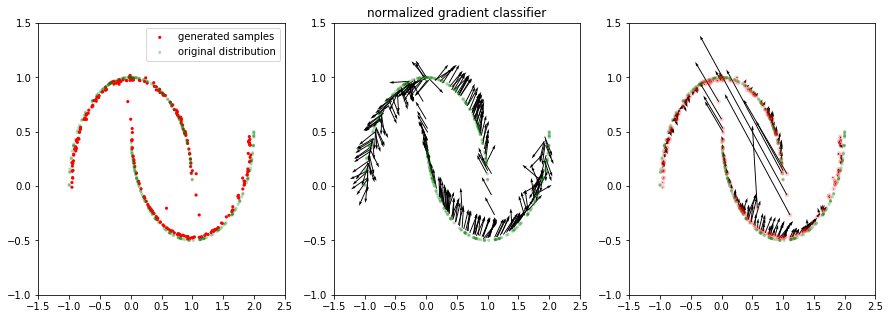

In [36]:
# xx, zz = sess.run([samples,samples_perturb])
uu,xx, yy = sess.run([_nabla,samples, data]) # _nabla = tf.gradients(logits_gen, noise)[0]
# uu = zz - xx 
norm = np.linalg.norm(uu,axis=1,keepdims=1)
uu_n = uu / (norm * np.ones([1,2]))
n_quiver = 1000
print("global step:", sess.run(global_step))
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10,c='r')
plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
#         plt.scatter(zz[:, 0], zz[:, 1], edgecolor='none',s=10,alpha = 0.3)
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
plt.legend(['generated samples','original distribution'])

plt.subplot(132)
plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu_n[:n_quiver,0], uu_n[:n_quiver,1],scale = 12)
plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
#         plt.legend(['normalized local perturabtion','samples original distrinbution'])
plt.title('normalized gradient classifier')

plt.subplot(133)
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu[:n_quiver,0], uu[:n_quiver,1])
plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
plt.scatter(xx[:n_quiver, 0], xx[:n_quiver, 1], edgecolor='none',s=20,c='r',alpha = 0.2)
#         plt.scatter(zz[:n_quiver, 0], zz[:n_quiver, 1], edgecolor='none',s=20)
#         for i in range(n_quiver):
#             plt.arrow(xx[i,0], xx[i,1], uu[i,0], uu[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k',alpha=0.4,color='r')

plt.show()

In [85]:
tangent_norm = tf.nn.l2_normalize(_nabla,dim=1) # _nabla = tf.gradients(logits_gen, noise)[0]
print(tangent)
gen_adv = generator(noise+0.001 * tangent_norm)
print(gen_nabla)

Tensor("l2_normalize_2:0", shape=(256, 2), dtype=float32)
Tensor("generator_3/fully_connected/BiasAdd:0", shape=(256, 2), dtype=float32)


In [86]:
zz, xx, yy = sess.run([gen_adv, samples,data]) # _nabla = tf.gradients(logits_gen, noise)[0]

global step: 4122


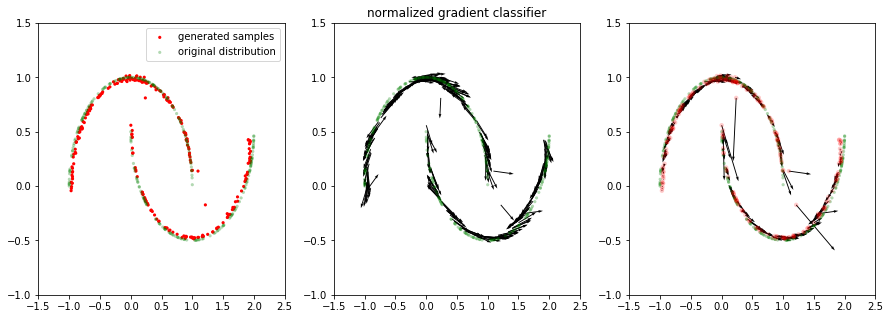

In [87]:
uu = zz - xx 
norm = np.linalg.norm(uu,axis=1,keepdims=1)
uu_n = uu / (norm * np.ones([1,2]))
n_quiver = 1000
print("global step:", sess.run(global_step))
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10,c='r')
plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
#         plt.scatter(zz[:, 0], zz[:, 1], edgecolor='none',s=10,alpha = 0.3)
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
plt.legend(['generated samples','original distribution'])

plt.subplot(132)
plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu_n[:n_quiver,0], uu_n[:n_quiver,1],scale = 12)
plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
#         plt.legend(['normalized local perturabtion','samples original distrinbution'])
plt.title('normalized gradient classifier')

plt.subplot(133)
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu[:n_quiver,0], uu[:n_quiver,1])
plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
plt.scatter(xx[:n_quiver, 0], xx[:n_quiver, 1], edgecolor='none',s=20,c='r',alpha = 0.2)
plt.show()

In [70]:
uu

array([[-1.0427966 ,  1.206099  ],
       [ 1.7424668 ,  0.03481787],
       [ 0.84503466,  0.22778562],
       [-0.04228854, -1.194557  ],
       [ 0.730656  , -0.508505  ],
       [-0.25974676,  0.15023178],
       [-0.8300148 ,  0.6390779 ],
       [ 1.51301   , -0.4594379 ],
       [ 0.7987782 , -0.4809376 ],
       [ 0.59106004,  0.6398877 ],
       [ 0.63633937, -0.8543723 ],
       [ 1.3165367 ,  0.69026065],
       [ 1.2680515 , -0.6406908 ],
       [ 0.1205765 , -0.09613818],
       [ 0.38041958,  0.8780363 ],
       [-0.81340104,  0.32991216],
       [ 0.6033149 , -1.2081707 ],
       [ 0.70303136, -1.4375002 ],
       [ 0.38252842, -1.0604655 ],
       [ 1.6531479 , -0.36707145],
       [ 0.25126722, -1.3213084 ],
       [-0.02001423,  0.01154268],
       [ 2.3006985 , -0.85633445],
       [ 1.6937511 , -0.9819589 ],
       [ 2.126041  , -0.94361216],
       [ 1.3658468 , -0.85058755],
       [ 0.3686789 ,  0.8399279 ],
       [-0.93348324, -0.7021901 ],
       [ 0.560743  ,